## Full matrix representation - version 1

The full version of the transportation model will allow for any number of patches and any number of connecting corridors between each pair of patches. The state variables will thus be given with matrices. These matrices have to be aggregated and passed to `ODEProblem` (a function of the `DifferentialEquations` package) using the `ArrayPartition` object type.

This version allows for any number of patches, but a maximum of 1 connecting corridor for each pair of patches.

**Next steps:**
- Make $C$ into a 3D matrix so that each pair of patches can have any number of connecting corridors. Also make $\beta_1$ and $\beta_2$ 3D so that each corridor can have a different capacity, even compared to other corridors connecting the same origins and destinations.
- Convert traffic flows to average speeds and then to emissions (rates and total)
    - Try to model U-shaped curve with something like a (x-40)**4 + 1...


**Notes to self:**
- exp.(C) needed whenever C is a matrix. exp(C) tries to perform the matrix exponential, which is only defined for square matrices

In [2]:
using Plots
using LinearAlgebra
using LaTeXStrings
using Roots
using DifferentialEquations
using Interpolations
using RecursiveArrayTools
using QuadGK
using Printf

#### Function for system of equations
- State variables: populations in patches ($P$), populations in corridors ($C$), both passed with argument $N$
- Parameters: passed as an array with argument $p$
- time: argument $t$ gives a times span over which to solve the system

In [3]:
function sys_of_eqs(dN, N, p, t)
    #=
        Returns (change in place)
            - dN: VectorOfArrays, (P, C)
                    population values at next time step
        Arguments
            - dN: VectorOfArrays, (P, C)
                    population values at next time step
            - N: VectorOfArrays, (P, C)
                    population values at current time step
                    N = [P¹, P², C¹₁₂, C¹₂₁, C²₁₂, C²₂₁]
            - p: VectorOfArrays, size (3, ...)
                    parameters
                    p = [αᵢ, βₖ, pi_out]
    =#
    
    # get variables
    P = N.x[1]     # 1D array with n elements
    C = N.x[2]     # n x n matrix
    n = length(P)  # number of patches

    # get parameters
    α = p[1] # α[i] is aversion to congestion for travelers in patch i
    β = p[2] # β[i,j] accesses ith row, jth column (corridor from patch i to patch j)
    p_out = p[3] # p_out[i] is desire to leave for travelers in patch i

    # compute fluxes into and out of corridors
    F_p_to_c = Matrix{Float64}(undef, n, n)
    F_c_to_p = Matrix{Float64}(undef, n, n)
    eye = Matrix{Float64}(I, n, n)
    inverse_identity = ones(n, n) .- eye # ensures no travel from patch i to patch i

    F_p_to_c .= p_out .* exp.(-α .* β .* C) .* P .* inverse_identity # need to deal with p_out
    F_c_to_p .= exp.(-β .* C) .* C # deal with dimensions of beta

    # compute net population change for each patch and corridor
    P_lost = transpose(sum(F_p_to_c, dims=2)) # sum over rows, result is n x 1 matrix, so take transpose
    P_gained = sum(F_c_to_p, dims=1) # sum over columns, result is 1 x n matrix
    P_net = P_gained .- P_lost
    C_net = F_p_to_c .- F_c_to_p # do I need a transpose in here somewhere?
    #display(C_net)
    
    # update change variables
    dN.x[1] .= P_net # do I really need .=?
    dN.x[2] .= C_net
end

sys_of_eqs (generic function with 1 method)

#### Set initial conditions and parameters. Solve system of equations:

In [4]:
# Initial conditions
P0 = [25.0 25.0 25.0 25.0]
n = length(P0)
C0 = zeros(n, n)
#C0 = Matrix{Float64}(0.0, n, n)
#C0_col = [0.0, 0.0] #[0.0, 0.0]
#C0 = [C0_col 2 .* reverse(C0_col)]

# Make a simple matrix of β values (for now, all equal to 1 except along diagonal - we don't want patches that connect to themselves)
eye = Matrix{Float64}(I, n, n)
inverse_identity = ones(n, n) .- eye
manual_β = [0.0 1 1.0 1; 1 0 1 1; 1 1 0 1; 1 1 1 0] # Should be same as inverse identity
println(inverse_identity == manual_β)

# Parameters
Δt = 100.0
α_lst = repeat([1.0], n)
β_mtx = inverse_identity
p_out_lst = [2.0, 1.0, 0.5, 0.0] #repeat([1.0], n)
p = (α_lst, β_mtx, p_out_lst)
N0 = ArrayPartition(P0, C0)

# Solve system of equations
prob = ODEProblem(sys_of_eqs, N0, (0.0, Δt), p)
sol = solve(prob, Vern8())
#sol[1:10]

true


retcode: Success
Interpolation: specialized 8th order lazy interpolation
t: 27-element Vector{Float64}:
   0.0
   2.015729888682773e-5
   0.00015408304119696943
   0.0009974961698543132
   0.005878338546182471
   0.02029915381300694
   0.04833134466942973
   0.09832305678716483
   0.1869537721698857
   0.34386490907823475
   0.6207708345476839
   1.1077783428232166
   1.9617341027899435
   ⋮
  10.484388706576063
  17.95121502103355
  30.108750751390172
  49.065296676108886
  77.23264126637972
  79.8881350579778
  82.97036499543094
  87.22829783296386
  90.19956022146825
  92.66679636679571
  96.35823883896003
 100.0
u: 27-element Vector{ArrayPartition{Float64, Tuple{Matrix{Float64}, Matrix{Float64}}}}:
 ([25.0 25.0 25.0 25.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([24.996977981093035 24.998488634122506 24.999244234572174 25.00000001776281], [0.0 0.0010073168081840237 0.001007332025612834 0.0010073472454949729; 0.0005037700177156812 0.0 0.00050379285167

In [5]:
display(C0)

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [6]:
sol[2][5:20]

16-element Vector{Float64}:
 0.0
 0.0005037700177156812
 0.0002519167316732186
 0.0
 0.0010073168081840237
 0.0
 0.00025192434429674107
 0.0
 0.001007332025612834
 0.0005037928516752428
 0.0
 0.0
 0.0010073472454949729
 0.0005038004654491893
 0.0002519319593747347
 0.0

### Efficient plotting routine
- Linestyles - origin patch
- Colors - destination patch

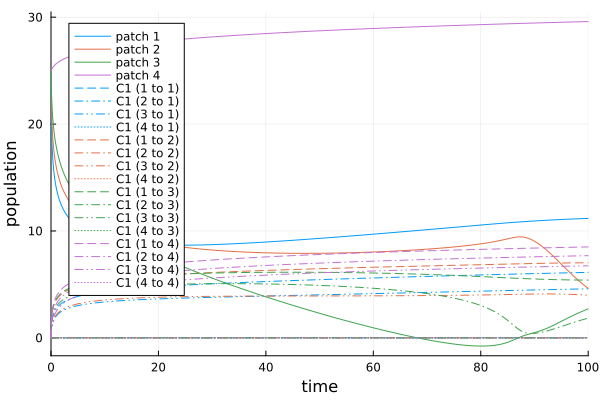

In [7]:
# Plot patch populations
plt = plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
plot!(sol, idxs = (0,2), xlabel="time", ylabel="population", label="patch 2")
plot!(sol, idxs = (0,3), xlabel="time", ylabel="population", label="patch 3")
plot!(sol, idxs = (0,4), xlabel="time", ylabel="population", label="patch 4")

# Plot corridor populations
linestyles = [:dash, :dashdot, :dashdotdot, :dot]
linecolors = palette(:default) #[:tabblue, :taborange, :tabgreen, :tabpink]
for col_j in 1:n # loop through columns
    for row_i in 1:n # loop through rows
        sol_n = n + (col_j-1)*n + row_i
        plot!(sol, idxs = (0,sol_n), xlabel="time", ylabel="population", label="C1 ($row_i to $col_j)", ls=linestyles[row_i], lc=linecolors[col_j])
    end
end
display(plt)

## The following need to be updated to work with matrix representation of $C$ (rather than scalar representation)

### Functions to convert traffic densities to average speeds

In [ ]:
# Calculate speeds from densities
v_f = 90             # free-flow velocity, 90 km/hr, same for C1 and C2
C1_jam = 1 / β₁      # jam density for C1 (causes avg speed = 0)
C2_jam = 1 / β₂      # jam density for C2 (causes avg speed = 0)
C1_half = C1_jam / 2 # threshold density for C1 (causes avg speed = 1/2 free-flow speed)
C2_half = C2_jam / 2 # threshold density for C2 (causes avg speed = 1/2 free-flow speed)

function calc_space_mean_speed_alternative_greenshields(v_f, C, C_half; a=1)
    #=
        Returns:
            - u_s: float 
                average speed for vehicles in a given traffic flow. If negative, return 0.
        Arguments:
            - v_f: float
                free-flow velocity
            - C: float
                vehicle density (in corridor C)
            - C_half:
                threshold value of vehicle density, where u_s = 1/2 * v_f
    =#
    u_s = - (v_f / pi) * atan(a*(C - C_half)) + (v_f / 2)
    return u_s > 0 ? u_s : 0
end

### Functions to convert average speeds to emission rates

In [ ]:
# Make a U-shaped curve using data from the California paper
start = 5
my_step = 5
stop = 100
mph_to_kmh = 1.60934
speed_arr = collect(start:my_step:stop) * mph_to_kmh # convert mph to kmh
emissions_arr = [1200, 950, 700, 500, 425, 350, 325, 310, 309, 308, 308, 308, 309, 320, 330, 350, 375, 400, 450, 550] * mph_to_kmh
plot(speed_arr, emissions_arr)

# Interpolate: emissions as a function of speed
interp_fn = linear_interpolation(speed_arr, emissions_arr, extrapolation_bc=Line())

# Calculate emissions from a given array of speeds
function calc_emissions_from_speed(vehicle_pop_arr, my_speed_arr, interp_fn)
    #=
        Returns:
            - emissions: array (dim 1) 
                emission rates (g/km) for whole traffic volume (all vehicles) at each
                time step
        Arguments:
            - vehicle_pop_arr: array (dim 1) of vehicle population densities at 
              each time step
            - my_speed_arr: array (dim 1) of avg vehicle speeds at each time step
            - interp_fn: function (interpolated) relating speeds to emissions
    =#
    interpolated_emission_per_vehicle = interp_fn(my_speed_arr)
    emissions = interpolated_emission_per_vehicle .* my_speed_arr .* vehicle_pop_arr
    return emissions
end

# NOT USED - Calculate flow volume
function calc_flow(vehicle_pop_arr, v_f, k_jam)
    q = v_f .* vehicle_pop_arr - (v_f / k_jam) .* vehicle_pop_arr.^2
    return q
end

### Functions to convert emissions rates to total emissions

In [ ]:
function integrate_emissions(x, y, a, b)
    # Create an interpolation function over data points
    interp_func = LinearInterpolation(x, y, extrapolation_bc=Line())

    # Integrate the interpolated function from a to b
    result, error = quadgk(interp_func, a, b)

    return result, error
end

### Calculated expected emissions for this travel

In [ ]:
# Calculate emission rates for C1
pop_C1 = sol[3, :]
time = sol.t
C1_speeds = calc_space_mean_speed_alternative_greenshields.(v_f, pop_C1, C1_half)
C1_emissions = calc_emissions_from_speed(pop_C1, C1_speeds, interp_fn)
C1_flow = calc_flow(pop_C1, v_f, C1_jam)

# Same for C2
pop_C2 = sol[5, :]
time = sol.t
C2_speeds = calc_space_mean_speed_alternative_greenshields.(v_f, pop_C2, C2_half)
C2_emissions = calc_emissions_from_speed(pop_C2, C2_speeds, interp_fn)
C2_flow = calc_flow(pop_C2, v_f, C2_jam)

# Total emissions
C1_total_emissions = integrate_emissions(time, C1_emissions, 0.0, 100.0)[1] # [1] for value, [2] for error
formatted_C1_em = @sprintf("%.3f", C1_total_emissions)

C2_total_emissions = integrate_emissions(time, C2_emissions, 0.0, 100.0)[1]
formatted_C2_em = @sprintf("%.3f", C2_total_emissions)

Total_emissions = C1_total_emissions + C2_total_emissions
formatted_T_em = @sprintf("%.3f", Total_emissions)

C1_fraction_emissions = 100 * C1_total_emissions / Total_emissions
formatted_C1_fraction = @sprintf("%.2f", C1_fraction_emissions)

C2_fraction_emissions = 100 * C2_total_emissions / Total_emissions
formatted_C2_fraction = @sprintf("%.2f", C2_fraction_emissions)

### Old (please ignore everything from here down)
Plotting routine -- 4 patches

In [ ]:
# Plot each population over time
# Order goes down each column first (go through all the rows) and then through the columns
plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
plot!(sol, idxs = (0,2), xlabel="time", ylabel="population", label="patch 2")
plot!(sol, idxs = (0,3), xlabel="time", ylabel="population", label="patch 3")
plot!(sol, idxs = (0,4), xlabel="time", ylabel="population", label="patch 4")
plot!(sol, idxs = (0,5), xlabel="time", ylabel="population", label="C1 (1 to 1)", ls=:dash)
plot!(sol, idxs = (0,6), xlabel="time", ylabel="population", label="C1 (2 to 1)", ls=:dashdot)
plot!(sol, idxs = (0,7), xlabel="time", ylabel="population", label="C1 (3 to 1)", ls=:dashdotdot)
plot!(sol, idxs = (0,8), xlabel="time", ylabel="population", label="C1 (4 to 1)", ls=:dot)
plot!(sol, idxs = (0,9), xlabel="time", ylabel="population", label="C1 (1 to 2)", ls=:dash)
plot!(sol, idxs = (0,10), xlabel="time", ylabel="population", label="C1 (2 to 2)", ls=:dashdot)
plot!(sol, idxs = (0,11), xlabel="time", ylabel="population", label="C1 (3 to 2)", ls=:dashdotdot)
plot!(sol, idxs = (0,12), xlabel="time", ylabel="population", label="C1 (4 to 2)", ls=:dot)
plot!(sol, idxs = (0,13), xlabel="time", ylabel="population", label="C1 (1 to 3)", ls=:dash)
plot!(sol, idxs = (0,14), xlabel="time", ylabel="population", label="C1 (2 to 3)", ls=:dashdot)
plot!(sol, idxs = (0,15), xlabel="time", ylabel="population", label="C1 (3 to 3)", ls=:dashdotdot)
plot!(sol, idxs = (0,16), xlabel="time", ylabel="population", label="C1 (4 to 3)", ls=:dot)
plot!(sol, idxs = (0,17), xlabel="time", ylabel="population", label="C1 (1 to 4)", ls=:dash)
plot!(sol, idxs = (0,18), xlabel="time", ylabel="population", label="C1 (2 to 4)", ls=:dashdot)
plot!(sol, idxs = (0,19), xlabel="time", ylabel="population", label="C1 (3 to 4)", ls=:dashdotdot)
plot!(sol, idxs = (0,20), xlabel="time", ylabel="population", label="C1 (4 to 4)", ls=:dot)

#plt = plot!(sol, idxs = (0,16), xlabel="time", ylabel="population", label="C1 (3 to 4)")
#savefig(plt, "julia_plots/traffic_flows_matrix_note_β₁_$β₁" * "_β₂_$β₂" * ".png")
#display(plt)

2 patches 2D

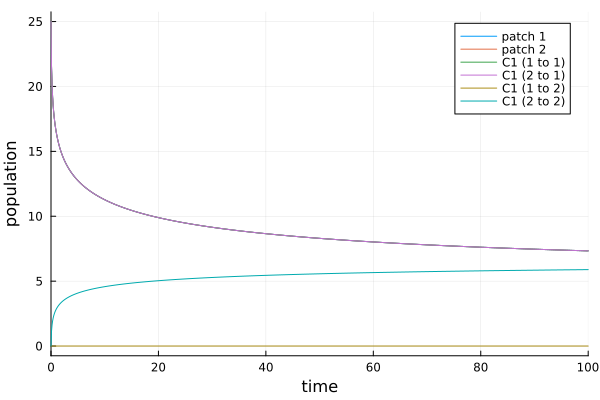

In [22]:
# Plot each population over time
plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
plot!(sol, idxs = (0,2), xlabel="time", ylabel="population", label="patch 2")
plot!(sol, idxs = (0,3), xlabel="time", ylabel="population", label="C1 (1 to 1)")
plot!(sol, idxs = (0,4), xlabel="time", ylabel="population", label="C1 (2 to 1)")
plot!(sol, idxs = (0,5), xlabel="time", ylabel="population", label="C1 (1 to 2)")
plt = plot!(sol, idxs = (0,6), xlabel="time", ylabel="population", label="C1 (2 to 2)")
#savefig(plt, "julia_plots/traffic_flows_matrix_note_β₁_$β₁" * "_β₂_$β₂" * ".png")
#display(plt)

In [124]:
sol[1:4]

retcode: Success
Interpolation: specialized 8th order lazy interpolation
t: 4-element Vector{Float64}:
 0.0
 1.5616508574188565e-5
 0.00012176761393534051
 0.0007582063023105114
u: 4-element Vector{ArrayPartition{Float64, Tuple{Matrix{Float64}, Matrix{Float64}}}}:
 ([90.0 10.0], [0.0 0.0; 0.0 0.0])
 ([89.99984386903314 9.998595503430446], [0.0 0.00015614070665769368; 0.001404486829754644 0.0])
 ([89.99878438855147 9.98910067523653], [0.0 0.0012161973939217648; 0.010898738818083304 0.0])
 ([89.99249584015409 9.933993900910021], [0.0 0.007525516118305271; 0.06598474281758454 0.0])

### Old
Would this have worked if I had finished indexing on C?

In [8]:
function traffic_flow!(dN, N, p, t)
    P¹ = N[1]      # population in patch 1
    P² = N[2]      # population in patch 2
    C¹₁₂ = N[3]    # population in corridor 1, lane from patch 1 to patch 2
    C¹₂₁ = N[4]    # population in corridor 1, lane from patch 2 to patch 1
    C²₁₂ = N[5]    # population in corridor 2, lane from patch 1 to patch 2
    C²₂₁ = N[6]    # population in corridor 2, lane from patch 2 to patch 1

    α₁ = p[1]       # tolerance for congestion, originators in patch 1
    α₂ = p[2]       # tolerance for congestion, originators in patch 2
    β₁ = p[3]       # inverse road capacity, corridor 1
    β₂ = p[4]       # inverse road capacity, corridor 2
    p1_out = p[5]   # overall demand for leaving P1
    p2_out = p[6]   # overall demand for leaving P2

    for i in 1:n
        for j in 1:n
            Fₚᶜᵏ[i,j] = [p1_out * exp(-β₁ * α₁ * Cᵏ[i,j]) * P[i]] # flux from patch i into corridor k heading in the j direction
            Fᵪₖᵖ = exp(-β₁ * Cᵏ[i,j]) * C[i,j]                    # flux from corridor k (heading from patch i to patch j) into patch j
        end
    end

    # Fluxes
    F₁ᶜ¹ = p1_out * exp(-β₁ * α₁ * C¹₁₂) * P¹   # flux from patch 1 into corridor 1 (implicitly heading towards patch 2)
    F₂ᶜ¹ = p2_out * exp(-β₁ * α₂ * C¹₂₁) * P²   # flux from patch 2 into corridor 1 (implicitly heading towards patch 1)
    F₁ᶜ² = p1_out * exp(-β₂ * α₁ * C²₁₂) * P¹   # flux from patch 1 into corridor 2 (implicitly heading towards patch 2)
    F₂ᶜ² = p2_out * exp(-β₂ * α₂ * C²₂₁) * P²   # flux from patch 2 into corridor 2 (implicitly heading towards patch 1)

    Fc₁¹ = exp(-β₁ * C¹₂₁) * C¹₂₁     # flux from corridor 1 into patch 1 (implicitly lane from p2 to p1)
    Fc₁² = exp(-β₁ * C¹₁₂) * C¹₁₂     # flux from corridor 1 into patch 2 (implicitly lane from p1 to p2)
    Fc₂¹ = exp(-β₂ * C²₂₁) * C²₂₁     # flux from corridor 2 into patch 1 (implicitly lane from p2 to p1)
    Fc₂² = exp(-β₂ * C²₁₂) * C²₁₂     # flux from corridor 2 into patch 2 (implicitly lane from p1 to p2)
    
    # Net changes to state variables
    dN[1] = Fc₁¹ + Fc₂¹ - F₁ᶜ¹ - F₁ᶜ² # change in population Patch 1
    dN[2] = Fc₁² + Fc₂² - F₂ᶜ¹ - F₂ᶜ² # change in population Patch 2
    dN[3] = F₁ᶜ¹ - Fc₁² # change in population Corridor 1 lane from p1 to p2
    dN[4] = F₂ᶜ¹ - Fc₁¹ # change in population Corridor 1 lane from p2 to p1
    dN[5] = F₁ᶜ² - Fc₂² # change in population Corridor 2 lane from p1 to p2
    dN[6] = F₂ᶜ² - Fc₂¹ # change in population Corridor 2 lane from p2 to p1
end
# Where to put conservation law??

traffic_flow! (generic function with 1 method)

In [10]:
# Choose parameters
α₁ = 1
α₂ = 1
β₁ = 10
β₂ = 60
p1_out = 1
p2_out = 0
p = [α₁, α₂, β₁, β₂, p1_out, p2_out]

P0 = [0.9, 0.1] # initial population in each patch
C0 = [0 0; 0 0] # assume max 1 corridor for each connection, and no connecting the same og and dest

# Solve diff eq
using DifferentialEquations
N0 = [1; 0.; 0; 0; 0; 0]
tspan = (0.0, 100.0)
prob = ODEProblem(traffic_flow!, N0, tspan, p)
sol = solve(prob)
using Plots
#plot(sol, idxs = (0, 1, 2))
plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
plot!(sol, idxs = (0,2), xlabel="time", ylabel="population", label="patch 2")
plot!(sol, idxs = (0,3), xlabel="time", ylabel="population", label="C1 (1 to 2), β₁=$β₁")
plot!(sol, idxs = (0,5), xlabel="time", ylabel="population", label="C2 (1 to 2), β₂=$β₂")
plot!(sol, idxs = (0,4), xlabel="time", ylabel="population", label="C1 (2 to 1), β₁=$β₁")
plot!(sol, idxs = (0,6), xlabel="time", ylabel="population", label="C2 (2 to 1), β₂=$β₂")

LoadError: UndefVarError: `Cᵏ` not defined